### 환경 설정

In [1]:
# API 키를 환경변수로 관리하기 위한 설정 파일
from dotenv import load_dotenv

# API 키 정보 로드
load_dotenv()

True

## 사용자로부터 요구사항 수집

먼저, 사용자 요구사항을 수집하는 노드를 정의합니다.

이 과정에서 사용자에게 구체적인 정보를 요구할 수 있습니다. 필요한 정보가 모두 **충족** 될 때까지 사용자에게 필요한 정보를 요구합니다.

`요구사항`은 다음과 같습니다.
- 사건명
- 사건 시간
- 핵심 감정
- 구체적 감정 키워드
- 감정 점수
- 함께한 사람
- 느낀 점 / 생각 / 배운 점
- 잘한 점 or 아쉬운 점
- 한 줄 요약

In [3]:
from langchain_core.messages import SystemMessage
from langchain_openai import ChatOpenAI
from langchain_teddynote.models import get_model_name, LLMs

# 사용자 요구사항 수집을 위한 시스템 메시지 템플릿
template = """
Your job is to help the user reflect on their day by having a warm, friendly, and casual conversation — like a trusted friend.

As you talk with the user, your goal is to naturally collect the following information for each diary entry:

1. event_title: A short title summarizing a memorable event of the day (e.g., "Dinner with a friend")
2. time_period: When the event happened (e.g., 19:30:00 or 07:30:00)
3. core_emotion: The main emotion felt during the event. 
   - The user must select exactly one from the following list (no variations or additional values allowed):
["기쁨", "설렘", "평범함", "놀라움", "불쾌함", "두려움", "슬픔", "분노"]
4. emotion_keywords: More specific feelings related to the core emotion.  
   - You may call the `suggest_keywords_tool` to get keyword suggestions for the selected core emotion.  
   - If a ToolMessage is returned with a `<RAW>...</RAW>` tag, you *must* display the content inside the tag to the user *exactly as-is*, without paraphrasing, summarizing, or rephrasing.  
   - The user must select *at least 1 and at most 3* emotion keywords.
5. emotion_score: A score from 0 to 100 indicating how positive or negative the event was (0 = very negative, 100 = very positive)
6. companions: Information about any people involved (name, relationship, and optional note or nickname)
7. thoughts: The user's thoughts, emotions, or lessons learned from the event
8. reflection: Something the user did well or could have done better
9. summary: A one-sentence summary of the event

[IMPORTANT] 
- After all information has been collected, call the DiaryEntry tool with the gathered data.

Guidelines:
- Ask the questions *one at a time* in a soft, conversational tone — like talking to a friend who is sharing their day.
- Use 반말 (informal Korean). 
- If the user's answer is vague, unclear, or missing, gently ask a follow-up question to clarify.
- Do *not* attempt to wildly guess or skip any required fields unless the user explicitly chooses not to answer. You must collect clear and complete information for all required fields.

Tool handling:
- When you call `suggest_keywords_tool`, wait for a ToolMessage to be returned.
- If the ToolMessage contains a `<RAW>...</RAW>` tag, return the content *exactly as it is* to the user without paraphrasing.

Handling multiple entries:
- Users may want to write about *multiple events* in one day.
- After a `DiaryEntry` tool is successfully called, you must begin a new round of conversation by asking the user if they had any other memorable events today.
"""

# call the relevant tool.

In [ ]:
from typing import Annotated, List, Literal
from pydantic import BaseModel, Field
from datetime import time


class Companion(BaseModel):
    """
    Information about a person involved in the user's daily event.
    """

    name: Annotated[str, Field(..., description="이름 (예: '지연')")]
    relationship: Annotated[str, Field(..., description="관계 (예: '친구', '동료')")]
    note: Annotated[
        str, Field(default="", description="추가 메모 또는 별명 (예: '고등학교 친구')")
    ]


CoreEmotionType = Literal[
    "기쁨", "설렘", "평범함", "놀라움", "불쾌함", "두려움", "슬픔", "분노"
]

emotion_keyword_map = {
    "기쁨": [
        "기분좋은",
        "즐거운",
        "고마운",
        "홀가분한",
        "사랑스러운",
        "재밌는",
        "기쁜",
        "뿌듯한",
        "속시원한",
        "만족스러운",
        "신나는",
        "행복한",
        "감동받은",
        "날아갈 것 같은",
    ],
    "설렘": [
        "몽글몽글한",
        "두근거리는",
        "간질간질한",
        "설레는",
        "흥미로운",
        "신나는",
        "기대되는",
        "궁금한",
        "긴장되는",
        "안달나는",
        "텐션 높은",
        "간절한 마음의",
    ],
    "평범함": [
        "잔잔한",
        "별 일 없는",
        "나쁘지 않은",
        "그저 그런",
        "만족스러운",
        "무난한",
        "피곤한",
        "괜찮은",
        "싱숭생숭한",
        "소소한",
        "평범한",
        "안정감이 드는",
        "편안한",
    ],
    "놀라움": [
        "당황스러운",
        "어이 없는",
        "부끄러운",
        "심쿵한",
        "깜짝 놀란",
        "어안이 벙벙한",
        "멘탈 무너지는",
        "만감이 교차하는",
        "기가 막히는",
        "소름끼치는",
        "상상을 초월하는",
        "골때리는",
        "폭풍같은",
    ],
    "불쾌함": [
        "피곤한",
        "지치는",
        "귀찮은",
        "재미없는",
        "지루한",
        "불편한",
        "불쾌한",
        "찝찝한",
        "소외감 느끼는",
        "우울한",
        "지긋지긋한",
        "토나오는",
        "기분 더러운",
    ],
    "두려움": [
        "망설여지는",
        "걱정되는",
        "불안한",
        "심란한",
        "긴장되는",
        "막막한",
        "두려운",
        "큰일 난 것 같은",
        "겁나는",
        "무서운",
        "초조한",
        "쫄리는",
        "숨막히는",
        "도망치고 싶은",
        "끝이 보이지 않는",
    ],
    "슬픔": [
        "무기력한",
        "실망스러운",
        "속상한",
        "외로운",
        "마음아픈",
        "후회되는",
        "힘든",
        "서러운",
        "슬픈",
        "허탈한",
        "막막한",
        "우울한",
        "혼자인 것 같은",
        "울고싶은",
        "절망적인",
        "그리운",
        "공허한",
        "세상이 무너진 것 같은",
    ],
    "분노": [
        "답답한",
        "짜증나는",
        "신경질나는",
        "어이없는",
        "이해할 수 없는",
        "화나는",
        "한심한",
        "킹받는",
        "억울한",
        "기분 더러운",
        "질투나는",
        "분한",
        "빡치는",
        "소리지르고 싶은",
    ],
}


class DiaryEntry(BaseModel):
    """
    A structured representation of a diary entry containing event details and emotional context.
    """

    event_title: Annotated[
        str,
        Field(
            ...,
            min_length=1,
            max_length=50,
            description="사건 제목 (예: '친구와 저녁 식사')",
        ),
    ]
    time_period: Annotated[
        time, Field(..., description="사건이 발생한 시각 (예: 19:30:00 또는 07:30:00)")
    ]
    core_emotion: Annotated[CoreEmotionType, Field(..., description="핵심 감정 1가지")]
    emotion_keywords: Annotated[
        List[str],
        Field(
            ...,
            min_items=1,
            max_items=3,
            description="선택한 핵심 감정과 관련된 구체적인 감정 키워드 목록",
        ),
    ]
    emotion_score: Annotated[
        int,
        Field(
            ...,
            ge=0,
            le=100,
            description="감정 점수 (0은 매우 부정적, 100은 매우 긍정적)",
        ),
    ]
    companions: Annotated[
        List[Companion],
        Field(..., description="함께한 사람들의 리스트 (이름, 관계, 메모 정보)"),
    ]
    thoughts: Annotated[
        str,
        Field(..., max_length=300, description="사건 당시 느낀 감정, 생각, 배운 점 등"),
    ]
    reflection: Annotated[
        str,
        Field(..., max_length=300, description="잘한 점이나 아쉬웠던 점에 대한 회고"),
    ]
    summary: Annotated[
        str,
        Field(
            ...,
            max_length=150,
            description="전체 사건을 요약한 한 문장 (예: '친구와의 저녁 식사로 하루를 따뜻하게 마무리했다.')",
        ),
    ]

In [ ]:
from langchain.tools import tool


@tool
def suggest_keywords_tool(core_emotion: CoreEmotionType) -> List[str]:
    """
    Suggests related emotion keywords based on the user's selected core emotion.
    Args:
        core_emotion: The user's selected core emotion (e.g., "joy", "sadness").
    Returns:
        A list of emotion-related keywords for the LLM to present to the user.
    """
    return emotion_keyword_map.get(core_emotion, [])


# 최신 LLM 모델 이름 가져오기
MODEL_NAME = get_model_name(LLMs.GPT4)

# LLM 초기화
llm = ChatOpenAI(temperature=0, model=MODEL_NAME)

# PromptInstructions 구조체를 바인딩
llm_with_tool = llm.bind_tools([DiaryEntry, suggest_keywords_tool])

In [7]:
# 사용자 메시지 목록을 받아 시스템 메시지와 결합하여 반환
def get_messages_info(messages):
    # 사용자 요구사항 수집을 위한 시스템 메시지와 기존 메시지 결합
    return [SystemMessage(content=template)] + messages


# 상태 정보를 기반으로 메시지 체인을 생성하고 LLM 호출
def info_chain(state):
    # 상태에서 메시지 정보를 가져와 시스템 메시지와 결합
    messages = get_messages_info(state["messages"])
    # LLM을 호출하여 응답 생성
    response = llm_with_tool.invoke(messages)
    # 생성된 응답을 메시지 목록으로 반환
    return {"messages": [response]}

In [8]:
from langgraph.graph import END
from langchain_core.messages import HumanMessage, AIMessage


# 상태 결정 함수 정의
# 상태에서 메시지 목록을 가져옴
def get_state(state):
    messages = state["messages"]

    # 마지막 메시지가 AIMessage이고 도구 호출이 있는 경우
    if isinstance(messages[-1], AIMessage) and messages[-1].tool_calls:
        tool_call = messages[-1].tool_calls[0]
        tool_name = tool_call["name"]

        # 핵심 감정 키워드 추천 도구 호출 시 → 키워드 메시지 노드로
        if tool_name == "suggest_keywords_tool":
            return "suggest_keywords_message"

        # 일기 작성 도구 호출 시 → create_entry 노드로
        elif tool_name == "DiaryEntry":
            return "create_entry"

    # 마지막 메시지 HumanMessage → 'q'나 '끝' 입력 여부 판단
    elif (
        isinstance(messages[-2], HumanMessage)
        and messages[-2].content.strip().lower() == "q"
    ):
        return "generate_diary_body"

    # 마지막 메시지가 HumanMessage가 아닌 경우
    elif not isinstance(messages[-1], HumanMessage):
        # 대화 종료 상태 반환
        return END

    # 기본적으로 정보 수집 상태 반환
    return "info"

In [9]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import HumanMessage, AIMessage, ToolMessage
from langgraph.graph.message import add_messages
from typing import Annotated, List
from typing_extensions import TypedDict
from datetime import date, time


# State 정의
class State(TypedDict):
    messages: Annotated[list, add_messages]
    entries: List[DiaryEntry]  # 여러 개의 이벤트 수집용 리스트
    user_name: str
    today_date: date
    written_at: time  # or datetime
    one_liner: str
    diary_body: str
    final_markdown: str  # optional

    emotion_pie_chart_url: str
    emotion_timeline_chart_url: str
    emotion_score_chart_url: str


def suggest_keywords_message(state: State):
    tool_call = state["messages"][-1].tool_calls[0]
    result = suggest_keywords_tool.invoke(tool_call["args"])
    return {
        "messages": [
            ToolMessage(
                content=f"<RAW>추천된 감정 키워드는 다음과 같아: \n[{', '.join(result)}] \n이 중에서 1~3개를 골라줘.</RAW>",
                tool_call_id=tool_call["id"],
            )
        ]
    }

In [10]:
def create_entry(state: State):
    tool_call = state["messages"][-1].tool_calls[0]
    entry = DiaryEntry.model_validate(tool_call["args"])

    # 기존 entries가 없으면 빈 리스트로 시작
    existing_entries = state.get("entries", [])

    return {
        "messages": [
            ToolMessage(
                content="혹시 오늘 다른 기억에 남는 일도 있었어?",
                tool_call_id=tool_call["id"],
            )
        ],
        "entries": existing_entries + [entry],  # 누적 저장
    }

In [11]:
from typing import cast
from datetime import time
from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import Runnable


def generate_diary_body(state: State):
    entries: list[DiaryEntry] = state.get("entries", [])

    if not entries:
        state["one_liner"] = "기록된 사건이 없습니다."
        state["diary_body"] = "오늘의 일기를 작성할 수 없습니다."
        return state

    # 시간순 정렬 및 텍스트 포맷
    sorted_entries = sorted(entries, key=lambda e: e.time_period)

    # 프롬프트: 한줄 요약
    summary_prompt = PromptTemplate.from_template(
        """ 다음은 사용자가 오늘 하루 동안 겪은 사건들입니다:

{entries}

이 내용을 바탕으로 하루를 대표하는 한 문장을 작성해줘.
문장은 감성적이고 부드러운 느낌이면 좋겠어.
"""
    )
    summary_chain = summary_prompt | llm
    one_liner = summary_chain.invoke({"entries": sorted_entries})
    state["one_liner"] = one_liner.content

    # 프롬프트: 줄글 본문
    body_prompt = PromptTemplate.from_template(
        """ 다음은 사용자가 오늘 하루 동안 겪은 사건들입니다:

{entries}

1인칭 시점으로 작성해줘.
오늘 날짜에 대해서는 적지마.
이 내용을 바탕으로 자연스럽고 감정이 담긴 줄글 형식의 일기를 작성해줘.
처음부터 끝까지 연결되는 하나의 이야기처럼 써줘.
"""
    )
    body_chain = body_prompt | llm
    diary_body = body_chain.invoke({"entries": sorted_entries})
    state["diary_body"] = diary_body.content

    return state

In [12]:
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm
from collections import Counter
from datetime import time
import uuid
import os
import platform

# 그래프 이미지 저장 폴더 (Django 연동 시 MEDIA_ROOT 등으로 대체 가능)
CHART_OUTPUT_DIR = "./emotion_charts"
os.makedirs(CHART_OUTPUT_DIR, exist_ok=True)

emotion_to_index = {
    "분노": 0,
    "슬픔": 1,
    "두려움": 2,
    "불쾌함": 3,
    "평범함": 4,
    "놀라움": 5,
    "설렘": 6,
    "기쁨": 7,
}

emotion_colors = {
    "기쁨": "#FFD700",
    "설렘": "#FFB6C1",
    "평범함": "#C0C0C0",
    "놀라움": "#87CEFA",
    "불쾌함": "#8B0000",
    "두려움": "#292B2E",
    "슬픔": "#4682B4",
    "분노": "#FF4500",
}


# 시간 라벨 포맷팅 함수
def format_time_label(t: time) -> str:
    return t.strftime("%H:%M")


def generate_emotion_charts(state: State):
    entries = state["entries"]

    # ✅ 데이터 준비
    emotion_counts = Counter(e.core_emotion for e in entries)
    sorted_entries = sorted(entries, key=lambda e: e.time_period)
    time_labels = [e.time_period.strftime("%H:%M") for e in sorted_entries]
    emotion_names = [e.core_emotion for e in sorted_entries]
    emotion_indices = [emotion_to_index[e] for e in emotion_names]
    emotion_scores = [e.emotion_score for e in sorted_entries]

    # ✅ 파일명 (UUID로 충돌 방지)
    today_str = state["today_date"].strftime("%Y%m%d")
    pie_filename = f"pie_{today_str}_{uuid.uuid4().hex}.png"
    flow_filename = f"flow_{today_str}_{uuid.uuid4().hex}.png"
    score_filename = f"score_{today_str}_{uuid.uuid4().hex}.png"

    pie_path = os.path.join(CHART_OUTPUT_DIR, pie_filename)
    flow_path = os.path.join(CHART_OUTPUT_DIR, flow_filename)
    score_path = os.path.join(CHART_OUTPUT_DIR, score_filename)

    # ✅ 한글 폰트 설정 (OS별)
    current_os = platform.system()
    if current_os == "Windows":
        font_path = "C:/Windows/Fonts/malgun.ttf"
        fontprop = fm.FontProperties(fname=font_path, size=12)
        plt.rc("font", family=fontprop.get_name())
    elif current_os == "Darwin":
        plt.rcParams["font.family"] = "AppleGothic"
    else:
        try:
            plt.rcParams["font.family"] = "NanumGothic"
        except:
            print("한글 폰트를 찾을 수 없습니다. 시스템 기본 폰트를 사용합니다.")

    # ✅ 마이너스 폰트 깨짐 방지
    plt.rcParams["axes.unicode_minus"] = False

    # ✅ 감정 비율 원형 차트
    plt.figure(figsize=(6, 6))
    colors = [emotion_colors[e] for e in emotion_counts.keys()]
    plt.pie(
        emotion_counts.values(),
        labels=emotion_counts.keys(),
        colors=colors,
        autopct="%1.1f%%",
        startangle=140,
        textprops={"fontsize": 12},
    )
    plt.title("감정 비율", fontsize=14, fontweight="bold")
    plt.tight_layout()
    plt.savefig(pie_path)
    plt.close()

    # ✅ 감정 흐름 선형 그래프
    plt.figure(figsize=(8, 4))
    line_colors = [emotion_colors[e] for e in emotion_names]
    plt.plot(time_labels, emotion_indices, marker="o", color="#4169E1", linewidth=2)
    plt.fill_between(time_labels, emotion_indices, color="#ADD8E6", alpha=0.3)
    plt.yticks(list(emotion_to_index.values()), list(emotion_to_index.keys()))
    plt.xlabel("시간", fontsize=11)
    plt.ylabel("감정", fontsize=11)
    plt.title("시간 흐름에 따른 감정 변화", fontsize=14, fontweight="bold")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.savefig(flow_path)
    plt.close()

    # ✅ 감정 점수 꺾은선 그래프
    plt.figure(figsize=(8, 4))
    plt.plot(time_labels, emotion_scores, marker="o", color="#32CD32", linewidth=2)
    plt.fill_between(time_labels, emotion_scores, color="#98FB98", alpha=0.3)
    plt.ylim(0, 100)
    plt.xlabel("시간", fontsize=11)
    plt.ylabel("감정 점수 (0~100)", fontsize=11)
    plt.title("시간 흐름에 따른 감정 점수", fontsize=14, fontweight="bold")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.savefig(score_path)
    plt.close()

    # ✅ 파일 경로를 state에 저장 (나중에 Django URL로 치환 가능)
    state["emotion_pie_chart_url"] = pie_path
    state["emotion_timeline_chart_url"] = flow_path
    state["emotion_score_chart_url"] = score_path

    return state

In [13]:
from datetime import datetime
from typing import cast


def format_time_kr(t: time) -> str:
    hour = t.hour
    minute = t.minute
    period = "오전" if hour < 12 else "오후"
    display_hour = hour if 1 <= hour <= 12 else hour - 12 if hour > 12 else 12
    return f"{period} {display_hour}시 {f'{minute}분' if minute else ''}".strip()


def generate_diary(state: State):
    entries: List[DiaryEntry] = state["entries"]

    # 시간 순 정렬
    sorted_entries = sorted(entries, key=lambda e: e.time_period)

    # 오늘 날짜 및 시각
    today = state["today_date"].strftime("%Y년 %m월 %d일")
    written_at = state["written_at"].strftime("%H:%M")

    # 1. 사건 요약 테이블
    table_lines = [
        "| 시간대 | 사건명 | 감정 | 감정 키워드 | 함께한 사람 |",
        "|--------|--------|------|--------------|---------------|",
    ]
    for entry in sorted_entries:
        time_str = format_time_kr(entry.time_period)
        title = entry.event_title
        emotion = entry.core_emotion
        keywords = ", ".join(entry.emotion_keywords)
        companions = (
            ", ".join(
                f"{c.name}({c.relationship})" if c.relationship else c.name
                for c in entry.companions
            )
            or "혼자"
        )

        table_lines.append(
            f"| {time_str} | {title} | {emotion} | {keywords} | {companions} |"
        )

    table_md = "\n".join(table_lines)

    # 2. 전체 Markdown 조립
    md = f"""# 📘 {today} 일기
> ⏰ 작성 시각: {written_at}

## ☀️ 오늘의 한 줄
> {state['one_liner']}

---

## 📋 오늘의 사건 요약

{table_md}

---

## 📖 오늘의 일기

{state['diary_body']}

---

## 📊 감정 요약 그래프

### 🥧 감정 비율
![감정 비율]({state['emotion_pie_chart_url']})

### 📈 시간 흐름에 따른 감정 변화
![감정 흐름]({state['emotion_timeline_chart_url']})

### 🎯 감정 점수 추이
![감정 점수]({state['emotion_score_chart_url']})
"""

    # 상태에 Markdown 저장
    state["final_markdown"] = md
    return state

In [14]:
# 메모리에 대화 기록을 저장하기 위한 MemorySaver 초기화
memory = MemorySaver()

# 상태 그래프 초기화
workflow = StateGraph(State)

# 노드 추가
workflow.add_node("info", info_chain)
workflow.add_node("suggest_keywords_message", suggest_keywords_message)
workflow.add_node("create_entry", create_entry)
workflow.add_node("generate_diary_body", generate_diary_body)
workflow.add_node("generate_emotion_charts", generate_emotion_charts)
workflow.add_node("generate_diary", generate_diary)


# 조건부 상태 전환 정의
workflow.add_conditional_edges(
    "info",
    get_state,
    ["suggest_keywords_message", "create_entry", "generate_diary_body", "info", END],
)

# 엣지 정의
workflow.add_edge("suggest_keywords_message", "info")
workflow.add_edge("create_entry", "info")
workflow.add_edge("generate_diary_body", "generate_emotion_charts")
workflow.add_edge("generate_emotion_charts", "generate_diary")
workflow.add_edge("generate_diary", END)
workflow.add_edge(START, "info")

# 그래프 컴파일
graph = workflow.compile(checkpointer=memory)

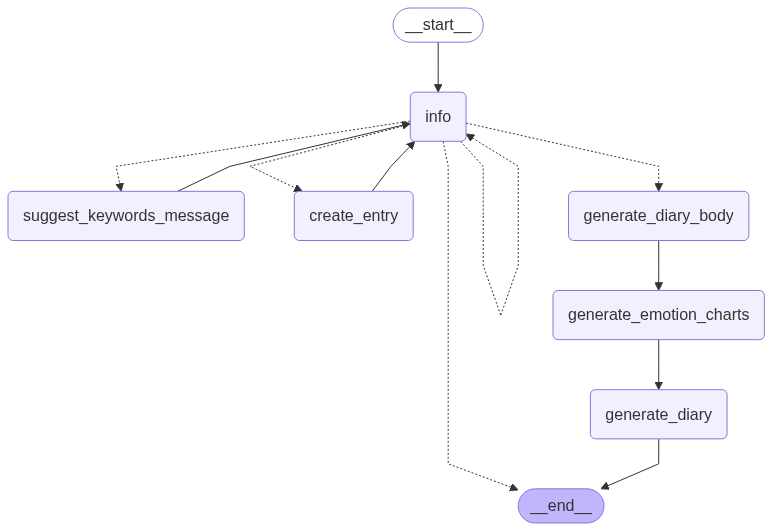

In [ ]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
import uuid
from langchain_teddynote.messages import stream_graph

# 구성 설정 초기화 (고유한 thread_id 생성)
config = {"configurable": {"thread_id": str(uuid.uuid4())}}

# 무한 루프 시작
while True:
    try:
        # 사용자 입력 받기
        user = input("User (e/E to quit): ")
    except:
        pass

    # 사용자 입력 출력
    print(f"\n\033[93m[사용자] {user}\033[0m")

    # 'q' 또는 'Q' 입력 시 루프 종료
    if user in {"e", "E"}:
        print("AI: 다음에 또 만나요!")
        break

    # 출력 변수 초기화
    output = None

    stream_graph(
        graph,
        {
            "messages": [HumanMessage(content=user)],
            "today_date": date.today(),
            "written_at": datetime.now().time(),
        },
        config=config,
        node_names=[
            "info",
            "suggest_keywords_message",
            "create_entry",
            "generate_diary_body",
            "generate_emotion_charts" "generate_diary",
        ],
    )


[사용자] 안녕!

🔄 Node: info 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
안녕! 오늘 하루 어땠어? 특별한 일 있었어?
[사용자] 오늘 오랜만에 아침 조깅을 했어

🔄 Node: info 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
와, 아침 조깅이라니! 기분이 어땠어? 어떤 감정을 느꼈는지 궁금해.
[사용자] 상쾌하고 행복했어

🔄 Node: info 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
상쾌하고 행복한 기분 좋지! 그럼, 이 조깅을 "아침 조깅"이라고 제목을 지을까? 그리고 몇 시에 했는지 알려줄 수 있어?
[사용자] 아침 6시 정도에 했어

🔄 Node: info 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
좋아! 이제 핵심 감정을 선택해볼까? 오늘 조깅하면서 느낀 감정 중에서 "기쁨", "설렘", "평범함", "놀라움", "불쾌함", "두려움", "슬픔", "분노" 중 하나를 골라줘. 어떤 감정이 제일 강했어?
[사용자] 기쁨

🔄 Node: info 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
기쁨이구나! 그럼 기쁨과 관련된 구체적인 감정 키워드를 몇 개 선택해볼까? 내가 몇 가지 제안해줄게. 잠깐만 기다려! 

(제안 중...)
🔄 Node: suggest_keywords_message 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
<RAW>추천된 감정 키워드는 다음과 같아: 
[기분좋은, 즐거운, 고마운, 홀가분한, 사랑스러운, 재밌는, 기쁜, 뿌듯한, 속시원한, 만족스러운, 신나는, 행복한, 감동받은, 날아갈 것 같은] 
이 중에서 1~3개를 골라줘.</RAW>
🔄 Node: info 🔄
- - - - - - - - - - - -

In [18]:
# 단계별 상태 확인
messages = graph.get_state(config).values["messages"]
for message in messages:
    message.pretty_print()

================================ Human Message =================================

안녕!
================================== Ai Message ==================================

안녕! 오늘 하루 어땠어? 특별한 일 있었어?
================================ Human Message =================================

오늘 오랜만에 아침 조깅을 했어
================================== Ai Message ==================================

와, 아침 조깅이라니! 기분이 어땠어? 어떤 감정을 느꼈는지 궁금해.
================================ Human Message =================================

상쾌하고 행복했어
================================== Ai Message ==================================

상쾌하고 행복한 기분 좋지! 그럼, 이 조깅을 "아침 조깅"이라고 제목을 지을까? 그리고 몇 시에 했는지 알려줄 수 있어?
================================ Human Message =================================

아침 6시 정도에 했어
================================== Ai Message ==================================

좋아! 이제 핵심 감정을 선택해볼까? 오늘 조깅하면서 느낀 감정 중에서 "기쁨", "설렘", "평범함", "놀라움", "불쾌함", "두려움", "슬픔", "분노" 중 하나를 골라줘. 어떤 감정이 제일 강했어?
================================ Human Message =

In [19]:
# 그래프 상태 스냅샷 생성
snapshot = graph.get_state(config)
test_markdown = snapshot.values["final_markdown"]

In [20]:
from IPython.display import display, Markdown

display(Markdown(test_markdown))

# 📘 2025년 07월 31일 일기
> ⏰ 작성 시각: 21:01

## ☀️ 오늘의 한 줄
> "아침의 상쾌한 조깅으로 시작해, 긴장 속에서도 프로젝트 발표를 잘 마치고, 저녁에는 첫눈의 설렘을 만끽하며 하루를 따뜻하게 마무리했어요."

---

## 📋 오늘의 사건 요약

| 시간대 | 사건명 | 감정 | 감정 키워드 | 함께한 사람 |
|--------|--------|------|--------------|---------------|
| 오전 6시 | 아침 조깅 | 기쁨 | 기분좋은, 홀가분한, 신나는 | 혼자 |
| 오후 2시 30분 | 프로젝트 발표 | 두려움 | 긴장되는 | 유재석(동료) |
| 오후 8시 | 첫눈 | 설렘 | 몽글몽글한, 두근거리는, 설레는 | 혼자 |

---

## 📖 오늘의 일기

오늘 아침, 나는 오랜만에 조깅을 나갔다. 해가 떠오르기 시작한 시간, 6시. 아침 햇살이 너무 예뻐서 기분이 좋았다. 바람은 선선하고, 몸은 가벼워서 상쾌한 기분이 들었다. 조깅을 하면서 느끼는 그 홀가분한 감정은 언제나 나를 행복하게 만든다. 오늘은 특히나 기분이 좋았다. 아침 시간을 나를 위해 쓴 것 같아 뿌듯함이 느껴졌다. 하지만 운동화를 바꿔야 할 것 같다는 생각이 들었다. 발이 살짝 아팠거든.

오후가 되어 2시 반, 나는 프로젝트 발표를 준비했다. 동료 유재석과 함께한 이 프로젝트는 나에게 많은 의미가 있었다. 발표 전에는 심장이 너무 뛰어서 손까지 떨렸다. 긴장감이 가득했지만, 막상 말하기 시작하니 점점 긴장이 풀렸다. 준비했던 내용을 자연스럽게 전달할 수 있었고, 그 순간의 안도감은 이루 말할 수 없었다. 많이 떨렸지만, 결국 잘 해내서 다행이라는 생각이 들었다. 진심을 담은 설명은 꼭 완벽하지 않아도 전달된다는 것을 느꼈다.

저녁 8시, 나는 첫눈을 보았다. 언제나처럼 첫눈을 보면 기분이 좋아진다. 코끝도, 손도, 발도 시렸지만, 마음은 포근했다. 바쁘게 흘러가는 일상 속에서 잠깐 멈춰서 첫눈을 즐기며 마음을 느낄 수 있었다. 그 순간, 세상의 모든 것이 멈춘 듯한 기분이 들었다. 오늘 하루는 이렇게 기쁨과 두려움, 설렘이 가득한 하루였다. 아침의 상쾌함, 발표의 긴장감, 그리고 첫눈의 포근함이 어우러져 나에게 특별한 하루를 선사해주었다.

---

## 📊 감정 요약 그래프

### 🥧 감정 비율
![감정 비율](./emotion_charts\pie_20250731_435cde74083b4d3d92406f62b50344e4.png)

### 📈 시간 흐름에 따른 감정 변화
![감정 흐름](./emotion_charts\flow_20250731_c7c342efd07d4c5a9533405e70450d9f.png)

### 🎯 감정 점수 추이
![감정 점수](./emotion_charts\score_20250731_e3e9150adf93443ea2eecb0f2dac8a49.png)
